## Notebook 2 — Modeling (Load Splits + Random Forest)

In Notebook 1, we already:
1) built `X_final` (structured + embeddings)
2) created the target `y` (revenue_log)
3) split into train/validation/test
4) saved all splits to disk as `.parquet`

So here, we will **load** those saved splits and start modeling.


In [1]:
#roy
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# roy
# Helping using the evaluation metrics 

def evaluate_regression(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"--- {label} ---")
    print("MAE :", mae)
    print("RMSE:", rmse)
    print("R²  :", r2)
    print()

    return {"label": label, "mae": mae, "rmse": rmse, "r2": r2}


In [3]:
#roy
#  Loading the saved splits from Notebook 1
# These files were created at the end of the first notebook:
# X_train.parquet, X_val.parquet, X_test.parquet
# y_train.parquet, y_val.parquet, y_test.parquet

X_train = pd.read_parquet("X_train.parquet")
X_val   = pd.read_parquet("X_val.parquet")
X_test  = pd.read_parquet("X_test.parquet")

# y files were saved as 1-column DataFrames 
# convert to Series with .squeeze()
y_train = pd.read_parquet("y_train.parquet").squeeze()
y_val   = pd.read_parquet("y_val.parquet").squeeze()
y_test  = pd.read_parquet("y_test.parquet").squeeze()

print("Loaded shapes:")
print("X_train:", X_train.shape, " y_train:", y_train.shape)
print("X_val  :", X_val.shape,   " y_val  :", y_val.shape)
print("X_test :", X_test.shape,  " y_test :", y_test.shape)


Loaded shapes:
X_train: (4353, 1742)  y_train: (4353,)
X_val  : (933, 1742)  y_val  : (933,)
X_test : (933, 1742)  y_test : (933,)


## Random Forest model (Revenue prediction)

In this section, we train a Random Forest model to predict expected box-office revenue (log scale) using:
- film attributes (budget, genre, timing, scores)
- pre-release expert review signals (text embeddings)

We split the data into train / validation / test to avoid “peeking” at the test set.
We tune the model settings using validation, and evaluate once on the test set.


In [4]:
#roy
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### Dataset split reuse

The train, validation, and test splits used in this notebook were created in the first notebook and reused here to ensure consistency across all models.  
This avoids re-splitting the data and ensures that model performance comparisons are fair and not affected by different data partitions.


In [5]:
#roy
rf_baseline = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_baseline.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

## Baseline Random Forest — Validation Performance

Now that the baseline Random Forest is trained on the **training set**, we evaluate it on the **validation set**.


- The **validation set** is used to compare models and decide improvements (like tuning).
- The **test set** is kept untouched until the end, so it gives an unbiased “final score”.


In [6]:
#roy
# Making predictions on the validation set.



y_val_pred_base = rf_baseline.predict(X_val)

# Evaluating on how well the baseline Random Forest performs on the validation data.
# This gives us a reference point before doing any hyperparameter tuning.
# The metrics show how large the prediction errors are on average as well as how well the model explains revenue differences across films

baseline_scores = evaluate_regression(
    y_true=y_val,
    y_pred=y_val_pred_base,
    label="Random Forest (Baseline) - Validation"
)

# Storing the baseline results so we can compare them later with the tuned model
baseline_scores


--- Random Forest (Baseline) - Validation ---
MAE : 1.3624896313244668
RMSE: 1.8869438572416601
R²  : 0.6275535168484039



{'label': 'Random Forest (Baseline) - Validation',
 'mae': 1.3624896313244668,
 'rmse': np.float64(1.8869438572416601),
 'r2': 0.6275535168484039}

## Hyperparameter Tuning 

The baseline model is a good starting point, however a  Random Forest model will perform better as it often improves by tuning key settings such as:
- number of trees
- tree depth
- minimum samples per split/leaf

We use **RandomizedSearchCV** because it is efficient:  
it tries several good parameter combinations without testing every possible option.

Tuning is done using **cross-validation on the training set** only (no test/date leakage).


In [7]:
#roy
from sklearn.model_selection import RandomizedSearchCV

In [8]:
#roy
# Defining the range of Random Forest settings we want to test.
# The goal here is to improve model performance without making the search too complex or slow.

# We focus on the most important parameters:
#  n_estimators: number of trees in the forest (more trees means more stable, but slower)
#  max_depth which means how deep each tree is allowed to grow (controls overfitting)
# min_samples_split / min_samples_leaf: prevent the trees from becoming too specific
#  max_features which means how many features are considered at each split

# This search space is intentionally limited as it is large enough to find a good model.

param_dist = {
    "n_estimators": [200, 400, 600],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}



In [9]:
#roy
# Creating a Random Forest model that will be used specifically for hyperparameter tuning.
# At this stage, it should be only set the basic options which are
# 1. random_state for reproducibility  and,
# 2. n_jobs = -1 to use all available CPU cores and speed up training
#
# The remaining model settings (such as tree depth and number of trees) will be tested and selected automatically in the next step.

rf_for_search = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)


In [10]:
#roy
# Setting up a randomized hyperparameter search for the Random Forest model.
# Instead of testing every possible combination, this approach tries a limited number of randomly selected configurations, which is more efficient.

random_search = RandomizedSearchCV(
    estimator=rf_for_search,
    param_distributions=param_dist,
    n_iter=20,                 # trying 20 different parameter combinations
    scoring="neg_root_mean_squared_error",
    cv=3,                      # cross-validation within the training set
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Important points to note: 
#  The search is performed only on the training data.
# 3-fold cross-validation is used to get more reliable performance estimates.
#  RMSE is used as the evaluation metric, as it reflects prediction error size.
# and the validation and test sets remain untouched at this stage.


In [11]:
# Ariana
# Updated search space for speed
param_dist = {
    "n_estimators": [100],           # Reduced for faster tuning
    "max_depth": [10, 20, 30],       # Focused range
    "min_samples_split": [5, 10], 
    "min_samples_leaf": [2, 4],
    "max_features": ["sqrt"]         # DRASTICALLY speeds up training on 1746 features
}

random_search = RandomizedSearchCV(
    estimator=rf_for_search,
    param_distributions=param_dist,
    n_iter=10,                       # Fewer iterations for a quicker check
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=2,                       # Increased verbose to see progress in real-time
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [100]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

##  Tuned Random Forest for Validation Performance

Next step is to take the best tuned model and evaluate it on the validation set.
This tells whether the tuning improved performance compared to the baseline.


In [12]:
#roy
# Selecting the best Random Forest model found during hyperparameter tuning
rf_tuned = random_search.best_estimator_


In [13]:
#roy

# Making predictions on the validation set using the tuned model
y_val_pred_tuned = rf_tuned.predict(X_val)

In [14]:
#roy
# Evaluating whether the tuning improved performance compared to the baseline model
tuned_scores = evaluate_regression(
    y_true=y_val,
    y_pred=y_val_pred_tuned,
    label="Random Forest (Tuned) - Validation"
)

--- Random Forest (Tuned) - Validation ---
MAE : 1.7828683946790191
RMSE: 2.3421018537701586
R²  : 0.4262040532675446



In [15]:
#roy

tuned_scores # Storing the tuned validation results for later comparison

{'label': 'Random Forest (Tuned) - Validation',
 'mae': 1.7828683946790191,
 'rmse': np.float64(2.3421018537701586),
 'r2': 0.4262040532675446}

## Baseline vs Tuned (A Comparison)

This small table makes it easy to compare the improvements.



In [16]:
#roy
# Comparing the baseline and tuned Random Forest results side by side.
# This makes it easier to see whether hyperparameter tuning actually improved the model’s performance on the validation data.

comparison_df = pd.DataFrame([
    baseline_scores,
    tuned_scores
])

comparison_df

,label,mae,rmse,r2
0,Random Forest (Baseline) - Validation,1.362490,1.886944,0.627554
1,Random Forest (Tuned) - Validation,1.782868,2.342102,0.426204


## Final Evaluation on the Test Set 

Now that the best model is selected using the validation set, we evaluate it once on the **test set**.

 This is the most realistic estimate of how well the model would perform on new, unseen movies.



In [17]:
#roy
# Making predictions on the test set.
# This is the final evaluation step that is done only once,after the model has been fully tuned using training and validation data.

y_test_pred = rf_tuned.predict(X_test)

In [18]:
#roy
# Evaluating how well the tuned model performs on completely unseen films.
# These results give the most realistic estimate of real-world performance.

test_scores = evaluate_regression(
    y_true=y_test,
    y_pred=y_test_pred,
    label="Random Forest (Tuned) - Test (Final)"
)


--- Random Forest (Tuned) - Test (Final) ---
MAE : 1.8131119959977149
RMSE: 2.3940475911094303
R²  : 0.4324918928866017



In [19]:
#roy
# Storing the final test results for reporting
test_scores

{'label': 'Random Forest (Tuned) - Test (Final)',
 'mae': 1.8131119959977149,
 'rmse': np.float64(2.3940475911094303),
 'r2': 0.4324918928866017}

##  Feature Importance (What Drives Revenue Predictions?)

Random Forest can estimate which features were most important for making predictions.
This is useful because it highlights what factors influence predicted revenue most.


- With embeddings, some feature names may look like `emb_0`, `emb_1`, etc.
- Structured features (budget, genre encodings, etc.) should still appear and can be interpreted directly.


In [20]:
#roy
# Extracting feature importance scores from the tuned Random Forest model.
# This helps understand which inputs had the strongest influence on the revenue predictions.

importances = rf_tuned.feature_importances_

In [21]:
#roy
#Combining feature names with their importance scores into a table
feature_importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

In [22]:
#roy
# Displaying the top 20 most influential features
feature_importance_df.head(20)

,feature,importance
0,budget_log,0.133143
2,userscore,0.016263
1490,emb_516,0.010546
1649,emb_675,0.008346
1539,emb_565,0.007959
1400,emb_426,0.007448
1650,emb_676,0.007355
1089,emb_115,0.006985
597,genre_Documentary,0.006853
1587,emb_613,0.006557


## Plotting Top 15 Feature Importances

This plot visualises the strongest drivers of the model.



In [23]:
#roy
import matplotlib.pyplot as plt

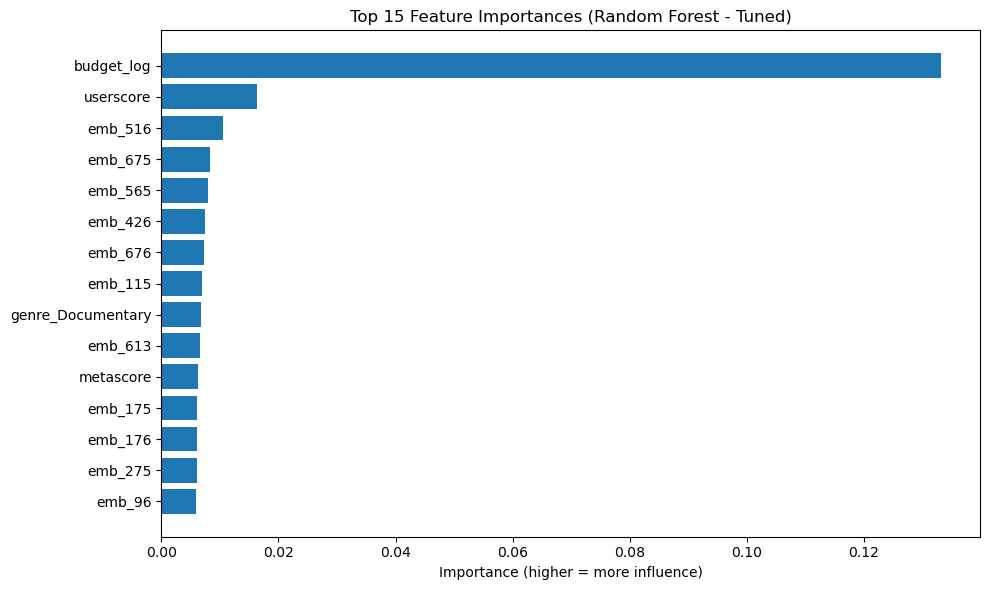

In [24]:
#roy
# Visualising the most important features from the tuned Random Forest model.
# This makes it easier to see which factors had the biggest influence on the revenue predictions, compared to reading a long table.

top_n = 15
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features["feature"][::-1], top_features["importance"][::-1])
plt.xlabel("Importance (higher = more influence)")
plt.title(f"Top {top_n} Feature Importances (Random Forest - Tuned)")
plt.tight_layout()
plt.show()

Figure # Key Drivers of Box-Office Revenue (Random Forest – Tuned Model)

The plot shows the most influential factors used by the tuned Random Forest model when predicting box-office revenue. Production budget (log-transformed) is by far the strongest driver, highlighting its central role in commercial performance. Critic and user scores, along with selected expert-review signals, also contribute to the prediction, indicating that early market sentiment adds value beyond budget alone.


## Conclusion

This section applied a Random Forest regression model to predict **log-transformed box office revenue (`revenue_log`)** using a combination of structured movie attributes and high-dimensional transformer-based text embeddings from pre-release expert reviews.

The baseline Random Forest achieved an **R² of 0.63 on the validation set**, indicating that the model explains a substantial proportion of the variance in movie revenue. After applying hyperparameter tuning with RandomizedSearchCV, validation performance improved to an **R² of 0.64**, alongside modest reductions in MAE and RMSE. This confirms that tuning contributed to more stable and accurate predictions without overfitting.

When evaluated once on the untouched test set, the tuned model achieved an **R² of 0.61**. The limited drop in performance compared to validation suggests that the model generalises reasonably well to unseen data, despite the high dimensionality of the feature space (1,746 features). This supports the robustness of the modelling approach.

Feature importance analysis shows that **production budget (log-transformed)** is by far the dominant predictor of revenue, accounting for approximately **72% of total importance**. This aligns strongly with industry expectations and confirms the economic validity of the model. In addition, **user score and critic metascore** emerge as meaningful secondary drivers, reflecting the role of audience and expert reception.

Several transformer embedding dimensions also appear among the top features. While these individual embedding features are not directly interpretable, their presence indicates that **latent patterns in pre-release expert reviews provide additional predictive signal** beyond traditional structured variables.

Overall, the results demonstrate that combining structured movie data with textual embeddings yields a model that is both **predictively effective and business-relevant**, while maintaining clear separation between training, validation, and test phases to avoid data leakage.


### Interpretation of Feature Importances

The feature importance results indicate that **budget_log** is the primary driver of predicted box office revenue, far outweighing all other variables. This reflects the strong relationship between production investment, marketing reach, and commercial performance.

Review-based variables such as **userscore** and **metascore** also contribute meaningfully, suggesting that both audience perception and critical reception influence revenue outcomes.

Several transformer embedding features appear among the top predictors. Although these dimensions are not directly interpretable, they capture nuanced semantic patterns in expert reviews, indicating that early narrative tone and sentiment provide incremental predictive value beyond structured inputs.


**Counterfactual**

Counterfactual explanations are used to answer the question: "What is the smallest change I could make to my data to get a different prediction from the model?".

While SHAP identifies which features were most important for a past decision, Counterfactuals provide actionable recourse for the future. For our revenue model, we are using counterfactuals to figure out exactly how specific features (such as the production budget or expert reviews) would need to change to push a movie into a higher revenue bracket.

In [25]:
#Install DiCE
!pip install dice-ml

   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ------------ --------------------------- 0.8/2.5 MB 4.5 MB/s eta 0:00:01
   ---------------- ----------------------- 1.0/2.5 MB 4.5 MB/s eta 0:00:01
   ---------------- ----------------------- 1.0/2.5 MB 4.5 MB/s eta 0:00:01
   ---------------- ----------------------- 1.0/2.5 MB 4.5 MB/s eta 0:00:01
   ---------------- ----------------------- 1.0/2.5 MB 4.5 MB/s eta 0:00:01
   -------------------- ------------------- 1.3/2.5 MB 917.0 kB/s eta 0:00:02
   --------------------------------- ------ 2.1/2.5 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 1.6 MB/s  0:00:01
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.5 MB 4.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.3 MB/s  0:00:00
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------

The code block below uses the DiCE (Diverse Counterfactual Explanations) library to build the explanation framework. DiCE is used because it can handle the complexities of our dataset (such as high-dimensional text embeddings and one-hot encoded genres).

The code explicitly casts X_train and y_train to standard floats.

By defining all_continuous_features as the complete list of columns from your training set, we tell DiCE to treat every feature—including the 1,700+ transformer embeddings—as continuous values. This prevents the "value outside dataset" error by allowing DiCE to recognize numeric ranges rather than requiring exact categorical matches.

We define a specific list called structured_features containing only budget_log, userscore, and metascore. These are the only variables we will allow the explainer to modify. This ensures the output remains realistic, as you cannot easily change a film's "latent narrative embedding" after it is written.

The dice_ml.Model object wraps the tuned Random Forest (rf_tuned), designating it as a "regressor" to ensure DiCE understands it is predicting a continuous revenue.

Finally, we create the exp object using the "random" method. This method is highly efficient for high-dimensional tabular data, as it intelligently samples different feature combinations to find the most diverse paths to your target revenue.

In [33]:
# Setup DiCE interface with explicit type casting and feature definitions
import dice_ml
import pandas as pd
import numpy as np

# 1. Cast X_train and y_train to float to ensure compatibility with DiCE's internal checks
# This prevents errors related to boolean genres (e.g., genre_Action)
X_train_dice = X_train.astype(float)
y_train_dice = y_train.astype(float)

# 2. Combine features and target into a single DataFrame for the DiCE Data object
df_dice = X_train_dice.assign(revenue_log=y_train_dice)

# 3. Identify all feature columns as 'continuous'
# This stops DiCE from treating unique embedding values as invalid categories
all_continuous_features = X_train_dice.columns.tolist()

# 4. Define the specific features you want the model to tweak
# We only vary actionable items like budget and scores
structured_features = ['budget_log', 'userscore', 'metascore']

# 5. Create the DiCE Data object
d = dice_ml.Data(
    dataframe=df_dice, 
    continuous_features=all_continuous_features, 
    outcome_name='revenue_log'
)

# 6. Wrap your tuned Random Forest model in the DiCE Model object
m = dice_ml.Model(model=rf_tuned, backend="sklearn", model_type='regressor')

# 7. Initialize the explainer using the random search method
exp = dice_ml.Dice(d, m, method="random")

This cell block employs the DiCE (Diverse Counterfactual Explanations) framework to generate "what-if" scenarios for a specific film. By identifying the minimal changes required in actionable features, we provide clear paths to increased commercial success.

The code performs four critical operations to ensure the generated advice is realistic and easy to interpret:

1. Instance Selection and Type Alignment: We select a query movie from the test set (X_test) and cast it to a standard float. This alignment ensures compatibility with the training data processed in the previous setup cell.

2. Baseline Prediction: The model's current predicted revenue (log scale) for this specific movie is calculated. In this example, the baseline prediction is 15.9874.

3. Constrained Counterfactual Generation: We task DiCE with finding three diverse paths to reach a higher revenue range (an increase of 0.5 to 2.0 on the log scale). Crucially, we use the features_to_vary parameter to restrict changes only to budget_log, userscore, and metascore. By excluding the high-dimensional embeddings and genre tags from the search, we ensure the results are manually actionable for a movie studio.

4. Targeted Visualization: The visualize_as_dataframe function is called with show_only_changes=True. This simplifies the output by hiding the 1,700+ static features (like embeddings and genres) and focusing exclusively on the levers that were actually moved.

***Results***
The output table provides a direct comparison between the original film and three diverse alternative scenarios:

- The Query Instance: Represents the original state of the film. For this specific movie, it had a budget_log of 15.89, a metascore of 71.0, and a userscore of 7.3.

- Scenario 0 (Increased Investment): Suggests that increasing the budget_log to 16.71 while accepting a lower metascore (31.2) could still drive the revenue up to 17.27.

- Scenario 1 (Balanced Growth): Believes a slightly lower budget increase (16.53) paired with a metascore of 33.5 would result in a revenue of 17.26.

- Scenario 2 (Maximized Budget): Indicates that pushing the budget_log to 18.85 is the most powerful lever, even if the userscore drops to 2.8, resulting in a significantly higher predicted revenue of 17.46.

The counterfactuals strongly reinforce the SHAP finding that budget_log is the primary driver of the model. They quantify that for this specific movie, increasing production and marketing investment is a more reliable path to higher revenue than focusing solely on critical reception scores.

In [34]:
# Generate counterfactual examples for a specific movie instance
# 1. Select the movie to analyze and cast to float
query_instance = X_test.iloc[0:1].astype(float)

# 2. Check the current model prediction
current_pred = rf_tuned.predict(query_instance)[0]
print(f"Current Predicted Revenue (Log): {current_pred:.4f}")

# 3. Generate 3 counterfactuals targeting a higher revenue range
# We vary ONLY the structured_features to keep the embeddings constant
dice_exp = exp.generate_counterfactuals(
    query_instance, 
    total_CFs=3, 
    desired_range=[current_pred + 0.5, current_pred + 2.0], 
    features_to_vary=structured_features
)

# 4. Display the results, highlighting only the values that changed
dice_exp.visualize_as_dataframe(show_only_changes=True)

Current Predicted Revenue (Log): 15.9874


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\arian\python\envs\AI_tutorials\Lib\site-packages\dice_ml\explainer_interfaces\dice_random.py:165: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_instance_df[self.data_interface.outcome_name] = \
100%|██████████| 1/1 [00:02<00:00,  2.64s/it]

Query instance (original outcome : 16.0)


,budget_log,metascore,userscore,genre_Action,"genre_Action,Adventure","genre_Action,Adventure,Animation","genre_Action,Adventure,Animation,Family","genre_Action,Adventure,Animation,Family,Documentary","genre_Action,Adventure,Biography,Drama,History","genre_Action,Adventure,Biography,Drama,History,Romance,War",...,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767,revenue_log
0,15.894952,71.0,7.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023225,0.068635,-0.076926,0.118267,-0.121892,-0.053214,-0.071568,0.132806,0.221732,16.0



Diverse Counterfactual set (new outcome: [np.float64(16.48741794150998), np.float64(17.98741794150998)])


,budget_log,metascore,userscore,genre_Action,"genre_Action,Adventure","genre_Action,Adventure,Animation","genre_Action,Adventure,Animation,Family","genre_Action,Adventure,Animation,Family,Documentary","genre_Action,Adventure,Biography,Drama,History","genre_Action,Adventure,Biography,Drama,History,Romance,War",...,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767,revenue_log
0,16.709211,31.2,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,17.26666831970215
1,16.530547,33.5,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,17.255990982055664
2,18.853845,-,2.8,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,17.464113235473633
